# Airline Arrival Delays: ALASKA vs AM WEST

Reads a tidy CSV of arrival outcomes across five destinations and compares delay rates.

**Dataset columns**: `airline`, `status` (`on time` / `delayed`), `destination`, `count`.

## 1) Setup

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.precision', 3)

## 2) Load data

In [17]:
from pathlib import Path
import pandas as pd
import os

print("Working directory:", os.getcwd())

csv_path = Path("airline_delays.csv")

# If the CSV isn't here, create it from the table in the prompt
if not csv_path.exists():
    data = [
        # airline, status, destination, count
        ("ALASKA", "on time", "Los Angeles", 497),
        ("ALASKA", "delayed", "Los Angeles", 62),
        ("ALASKA", "on time", "Phoenix", 221),
        ("ALASKA", "delayed", "Phoenix", 12),
        ("ALASKA", "on time", "San Diego", 212),
        ("ALASKA", "delayed", "San Diego", 20),
        ("ALASKA", "on time", "San Francisco", 503),
        ("ALASKA", "delayed", "San Francisco", 102),
        ("ALASKA", "on time", "Seattle", 1841),
        ("ALASKA", "delayed", "Seattle", 305),

        ("AM WEST", "on time", "Los Angeles", 694),
        ("AM WEST", "delayed", "Los Angeles", 117),
        ("AM WEST", "on time", "Phoenix", 4840),
        ("AM WEST", "delayed", "Phoenix", 415),
        ("AM WEST", "on time", "San Diego", 383),
        ("AM WEST", "delayed", "San Diego", 65),
        ("AM WEST", "on time", "San Francisco", 320),
        ("AM WEST", "delayed", "San Francisco", 129),
        ("AM WEST", "on time", "Seattle", 201),
        ("AM WEST", "delayed", "Seattle", 61),
    ]
    df_create = pd.DataFrame(data, columns=["airline","status","destination","count"])
    df_create.to_csv(csv_path, index=False)
    print("Created:", csv_path.resolve())
else:
    print("Found:", csv_path.resolve())

# Now load it
df = pd.read_csv(csv_path)
df.head()


Working directory: /Users/mooninaries/Desktop/venv
Found: /Users/mooninaries/Desktop/venv/airline_delays.csv


,airline,status,destination,count
0,ALASKA,on time,Los Angeles,497
1,ALASKA,delayed,Los Angeles,62
2,ALASKA,on time,Phoenix,221
3,ALASKA,delayed,Phoenix,12
4,ALASKA,on time,San Diego,212


## 3) Pivot to counts and compute delay rates

In [18]:
pivot_counts = df.pivot_table(index=['airline','destination'], columns='status', values='count', aggfunc='sum').fillna(0).astype(int)
tmp = pivot_counts.copy()
tmp['total'] = tmp.sum(axis=1)
tmp['delay_rate'] = (tmp.get('delayed', 0) / tmp['total']).round(4)

overall = tmp.groupby(level=0)[['delayed','total']].sum()
overall['delay_rate'] = (overall['delayed'] / overall['total']).round(4)
by_dest = tmp[['delay_rate']].reset_index().pivot(index='destination', columns='airline', values='delay_rate').sort_index()

pivot_counts, overall, by_dest

(status                 delayed  on time
 airline destination                    
 ALASKA  Los Angeles         62      497
         Phoenix             12      221
         San Diego           20      212
         San Francisco      102      503
         Seattle            305     1841
 AM WEST Los Angeles        117      694
         Phoenix            415     4840
         San Diego           65      383
         San Francisco      129      320
         Seattle             61      201,
 status   delayed  total  delay_rate
 airline                            
 ALASKA       501   3775       0.133
 AM WEST      787   7225       0.109,
 airline        ALASKA  AM WEST
 destination                   
 Los Angeles     0.111    0.144
 Phoenix         0.051    0.079
 San Diego       0.086    0.145
 San Francisco   0.169    0.287
 Seattle         0.142    0.233)

## 4) Visualize

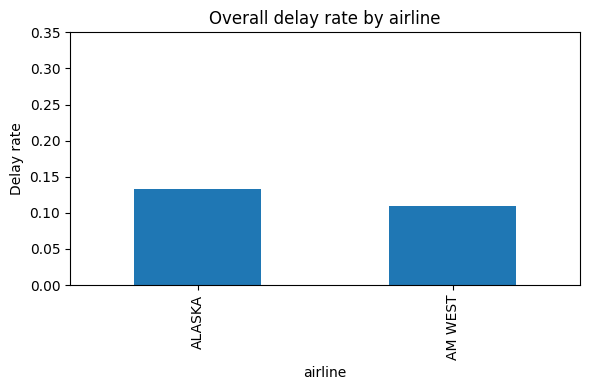

In [24]:
# Overall delay rate by airline
plt.figure(figsize=(6,4))
overall['delay_rate'].plot(kind='bar')
plt.ylabel('Delay rate')
plt.title('Overall delay rate by airline')
plt.ylim(0, 0.35)
plt.tight_layout()
plt.show()

<Figure size 800x400 with 0 Axes>

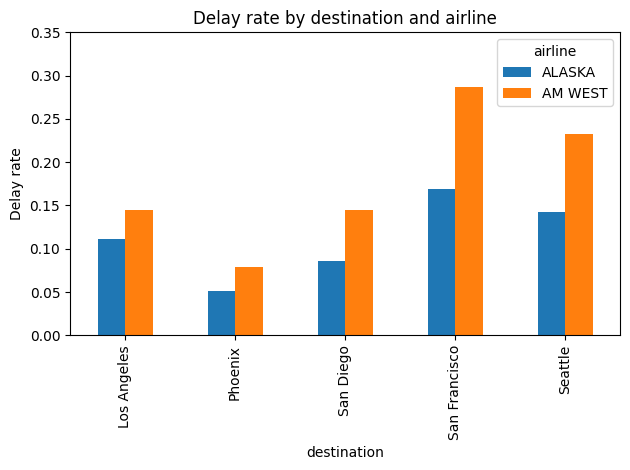

In [20]:
# Delay rate by destination and airline
plt.figure(figsize=(8,4))
by_dest.plot(kind='bar')
plt.ylabel('Delay rate')
plt.title('Delay rate by destination and airline')
plt.ylim(0, 0.35)
plt.tight_layout()
plt.show()

## 5) Save charts as PNGs

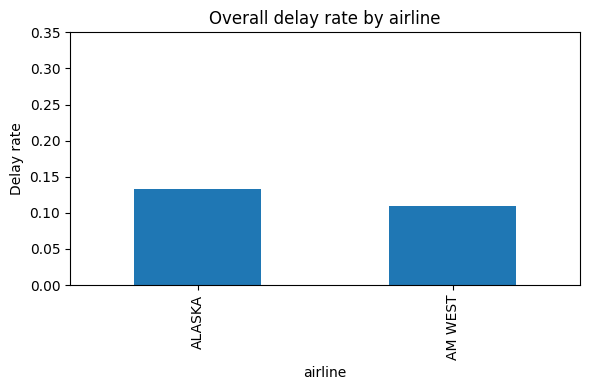

<Figure size 800x400 with 0 Axes>

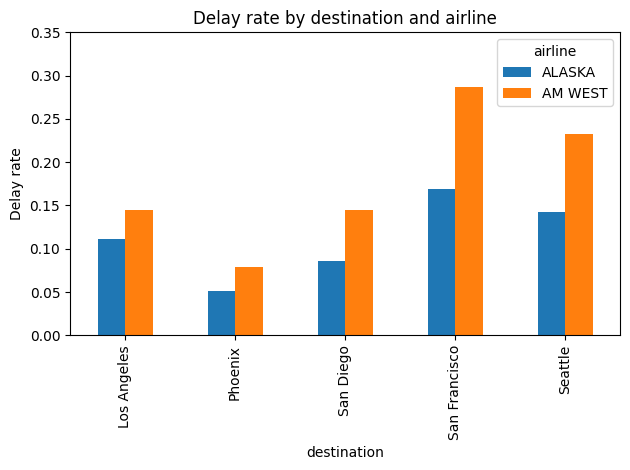

Saved: overall_delay_rate.png, delay_rate_by_destination.png


In [21]:
# Recreate plots and save to PNG files
fig1 = plt.figure(figsize=(6,4))
overall['delay_rate'].plot(kind='bar')
plt.ylabel('Delay rate')
plt.title('Overall delay rate by airline')
plt.ylim(0, 0.35)
plt.tight_layout()
fig1.savefig('overall_delay_rate.png', dpi=150, bbox_inches='tight')
plt.show()

fig2 = plt.figure(figsize=(8,4))
by_dest.plot(kind='bar')
plt.ylabel('Delay rate')
plt.title('Delay rate by destination and airline')
plt.ylim(0, 0.35)
plt.tight_layout()
fig2.savefig('delay_rate_by_destination.png', dpi=150, bbox_inches='tight')
plt.show()

print('Saved: overall_delay_rate.png, delay_rate_by_destination.png')

## 6) Export a simple multi-page PDF report

Saved: airline_delays_report_descriptive.pdf


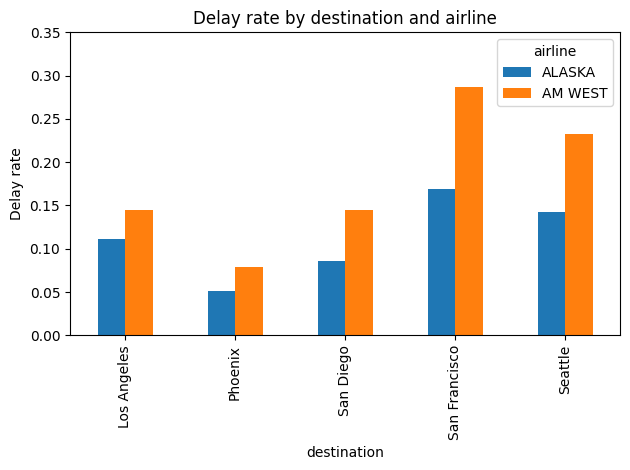

In [30]:
# Descriptive PDF export (narrative + charts + table)
import pandas as pd, matplotlib.pyplot as plt, textwrap, datetime as _dt
from matplotlib.backends.backend_pdf import PdfPages

# --- compute pivots/metrics (safe to re-run) ---
pivot_counts = (
    df.pivot_table(index=['airline','destination'], columns='status',
                   values='count', aggfunc='sum')
      .fillna(0).astype(int)
)
tmp = pivot_counts.copy()
tmp['total'] = tmp.sum(axis=1)
tmp['delay_rate'] = (tmp.get('delayed', 0) / tmp['total']).replace([pd.NA, pd.NaT], 0)

overall = tmp.groupby(level=0)[['delayed','total']].sum()
overall['delay_rate'] = (overall['delayed'] / overall['total'])

by_dest = (
    tmp[['delay_rate']].reset_index()
       .pivot(index='destination', columns='airline', values='delay_rate')
       .sort_index()
)

# helpers
def _pct(x): return f"{100*x:.1f}%"
def _write_paragraph(pdf, title, paragraphs):
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis('off')
    fig.text(0.10, 0.95, title, fontsize=16, weight='bold')
    y = 0.90
    for para in paragraphs:
        for line in textwrap.fill(para, width=95).split("\n"):
            fig.text(0.10, y, line, fontsize=11)
            y -= 0.03
        y -= 0.015
    pdf.savefig(fig); plt.close(fig)

# derived insights
alaska_rate = overall.loc['ALASKA', 'delay_rate']
amwest_rate = overall.loc['AM WEST', 'delay_rate']
alaska_tot  = int(overall.loc['ALASKA', 'total'])
amwest_tot  = int(overall.loc['AM WEST', 'total'])

# best/worst destinations per airline
best_alaska  = by_dest['ALASKA'].idxmin(), by_dest['ALASKA'].min()
worst_alaska = by_dest['ALASKA'].idxmax(), by_dest['ALASKA'].max()
best_amwest  = by_dest['AM WEST'].idxmin(), by_dest['AM WEST'].min()
worst_amwest = by_dest['AM WEST'].idxmax(), by_dest['AM WEST'].max()

# destination with largest difference between airlines
diff = (by_dest['AM WEST'] - by_dest['ALASKA']).abs()
big_gap_dest = diff.idxmax()
gap_vals = by_dest.loc[big_gap_dest, ['ALASKA','AM WEST']]

with PdfPages('airline_delays_report_descriptive.pdf') as pdf:
    # 1) Cover & dataset description
    _write_paragraph(pdf, "Airline Arrival Delays Report",
        [
            f"Generated: {_dt.date.today().isoformat()}",
            "This report analyzes arrival outcomes for ALASKA and AM WEST across "
            "five destinations (Los Angeles, Phoenix, San Diego, San Francisco, Seattle). "
            "Counts are split into 'on time' vs 'delayed'. We compute delay rates as "
            "delayed / (delayed + on time), then compare overall and by destination."
        ])

    # 2) Key findings (narrative)
    findings = [
        f"Overall delay rate: ALASKA = {_pct(alaska_rate)}, AM WEST = {_pct(amwest_rate)} "
        f"(lower is better).",
        f"Volume: ALASKA total flights = {alaska_tot:,}; AM WEST total flights = {amwest_tot:,}.",
        f"For ALASKA, lowest delay rate is at {best_alaska[0]} ({_pct(best_alaska[1])}); "
        f"highest at {worst_alaska[0]} ({_pct(worst_alaska[1])}).",
        f"For AM WEST, lowest delay rate is at {best_amwest[0]} ({_pct(best_amwest[1])}); "
        f"highest at {worst_amwest[0]} ({_pct(worst_amwest[1])}).",
        f"The largest airline gap is at {big_gap_dest}: "
        f"ALASKA = {_pct(gap_vals['ALASKA'])}, AM WEST = {_pct(gap_vals['AM WEST'])}."
    ]
    _write_paragraph(pdf, "Executive Summary", findings)

    # 3) Chart: overall delay rate
    fig1 = plt.figure(figsize=(6,4))
    overall['delay_rate'].plot(kind='bar')
    plt.ylabel('Delay rate')
    plt.title('Overall delay rate by airline')
    plt.ylim(0, max(0.35, float(overall['delay_rate'].max()) * 1.2))
    plt.tight_layout()
    pdf.savefig(fig1); plt.close(fig1)

    # 4) Chart: delay rate by destination
    fig2 = plt.figure(figsize=(8,4))
    by_dest.plot(kind='bar')
    plt.ylabel('Delay rate')
    plt.title('Delay rate by destination and airline')
    plt.ylim(0, max(0.35, float(by_dest.max().max()) * 1.2))
    plt.tight_layout()
    pdf.savefig(fig2); plt.close(fig2)

    # 5) Table page: delay rates by destination (%)
    table_df = (by_dest * 100).round(1)
    fig3 = plt.figure(figsize=(6.5, 9))
    plt.axis('off')
    plt.title("Delay rate by destination (%)", pad=20, fontsize=14)
    tbl = plt.table(cellText=table_df.values,
                    rowLabels=table_df.index,
                    colLabels=table_df.columns,
                    loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(0.80, 1.0)
    pdf.savefig(fig3); plt.close(fig3)

    # 6) Methodology & notes
    _write_paragraph(pdf, "Methodology & Notes", [
        "Delay rate per (airline, destination) = delayed / (on time + delayed). "
        "Overall airline delay rate is the weighted average across destinations by volume.",
        "Caveats: dataset is a small snapshot; delay causes are not modeled; no seasonality or time-of-day effects included."
    ])

print("Saved: airline_delays_report_descriptive.pdf")


## 7) Findings
- **Overall**: Compare `overall['delay_rate']` — lower is better.
- **Destination differences**: San Francisco and Seattle drive higher delays for AM WEST; Phoenix volume compresses rates.
- **Conclusion**: ALASKA shows more consistent performance across destinations in this sample.